#Setup and training

Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 1.0581525839292085, Val Loss: 0.9011101424694061, Train Acc: 0.4271356783919598, Val Acc: 0.5714285714285714
Epoch 2/100, Train Loss: 0.6150951637671545, Val Loss: 0.5852980613708496, Train Acc: 0.7311557788944724, Val Acc: 0.7755102040816326
Epoch 3/100, Train Loss: 0.5434730820930921, Val Loss: 2.1082427501678467, Train Acc: 0.8165829145728644, Val Acc: 0.5714285714285714
Epoch 4/100, Train Loss: 0.45533425418230206, Val Loss: 0.9105543792247772, Train Acc: 0.8115577889447236, Val Acc: 0.7346938775510204
Epoch 5/100, Train Loss: 0.33278097155002445, Val Loss: 1.669459879398346, Train Acc: 0.8944723618090452, Val Acc: 0.6530612244897959
Epoch 6/100, Train Loss: 0.433787003159523, Val Loss: 1.4111064076423645, Train Acc: 0.8668341708542714, Val Acc: 0.6326530612244898
Epoch 7/100, Train Loss: 0.22465970768378332, Val Loss: 0.3108765333890915, Train Acc: 0.9120603015075377, Val Acc: 0.8571428571428571
Epoch 8/100, Train Loss: 0.1688354776169245, Val Loss: 0.4950

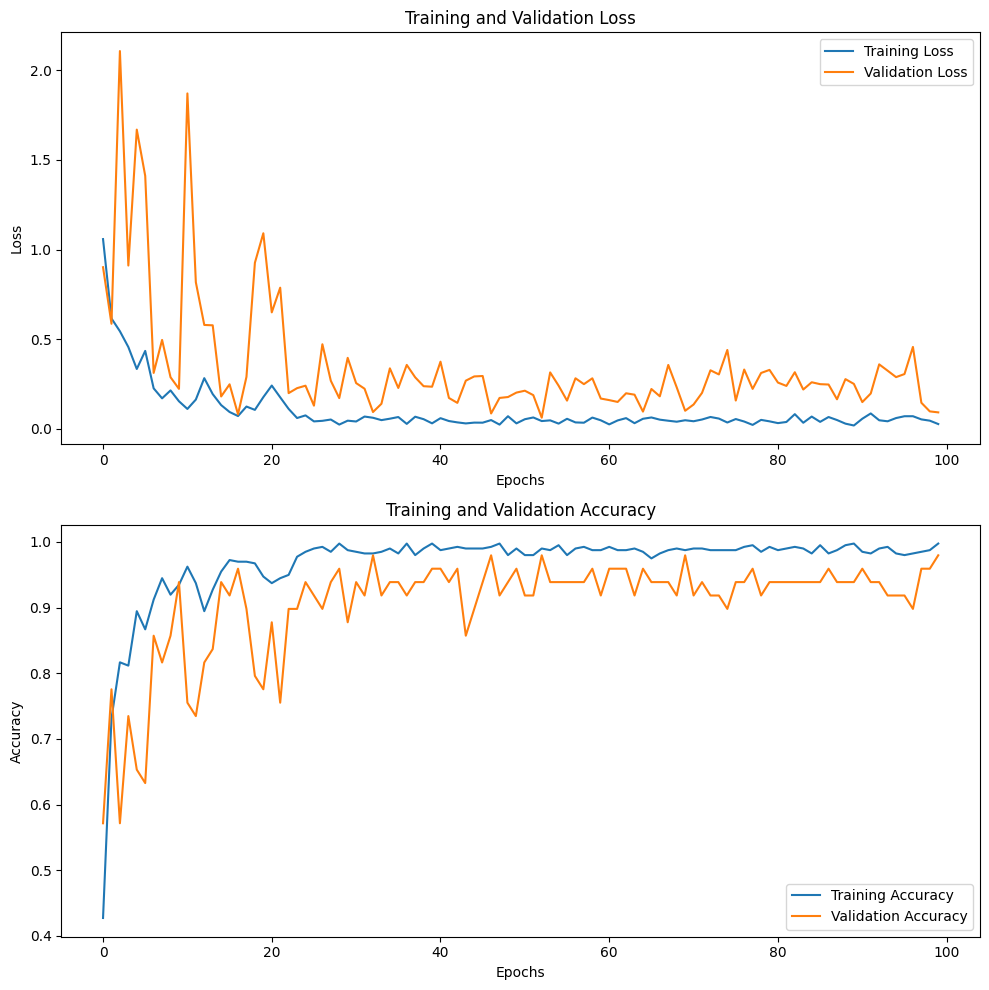

Test Accuracy: 0.9607843137254902


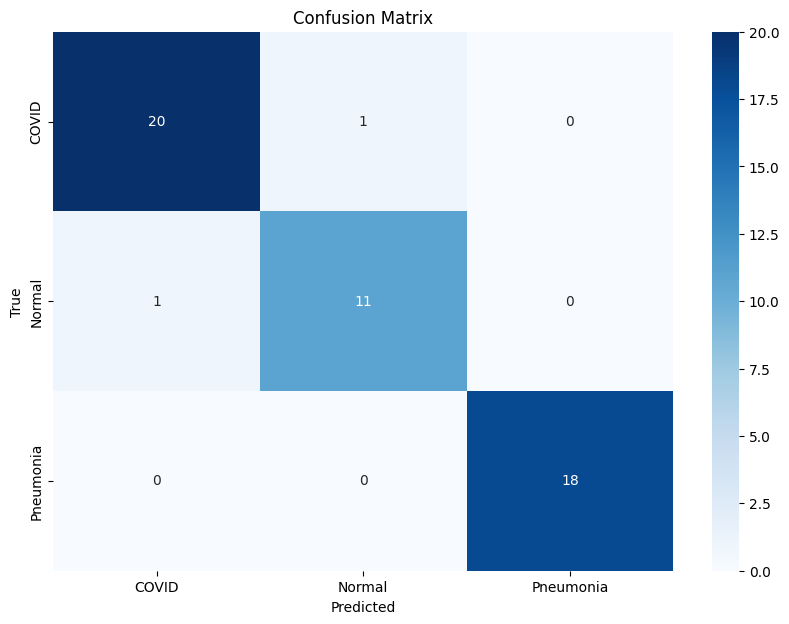

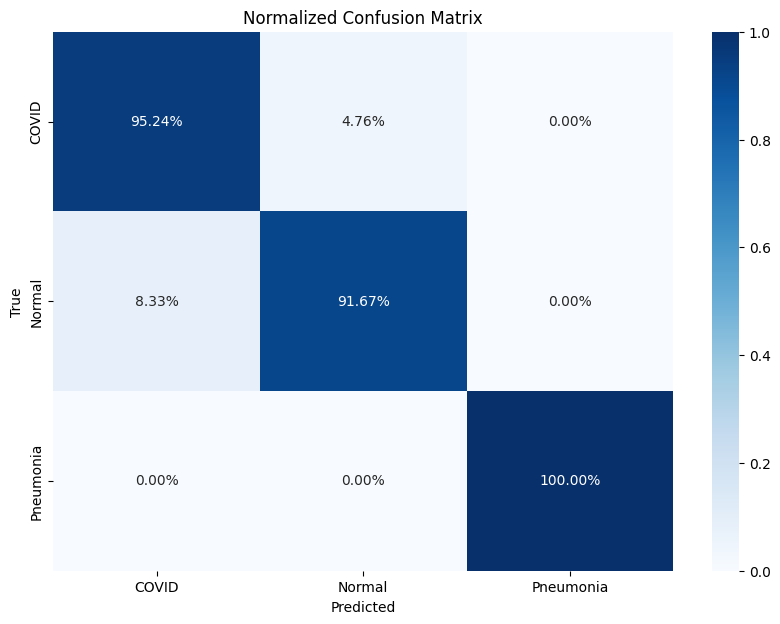

Classification Report:
              precision    recall  f1-score   support

       COVID       0.95      0.95      0.95        21
      Normal       0.92      0.92      0.92        12
   Pneumonia       1.00      1.00      1.00        18

    accuracy                           0.96        51
   macro avg       0.96      0.96      0.96        51
weighted avg       0.96      0.96      0.96        51



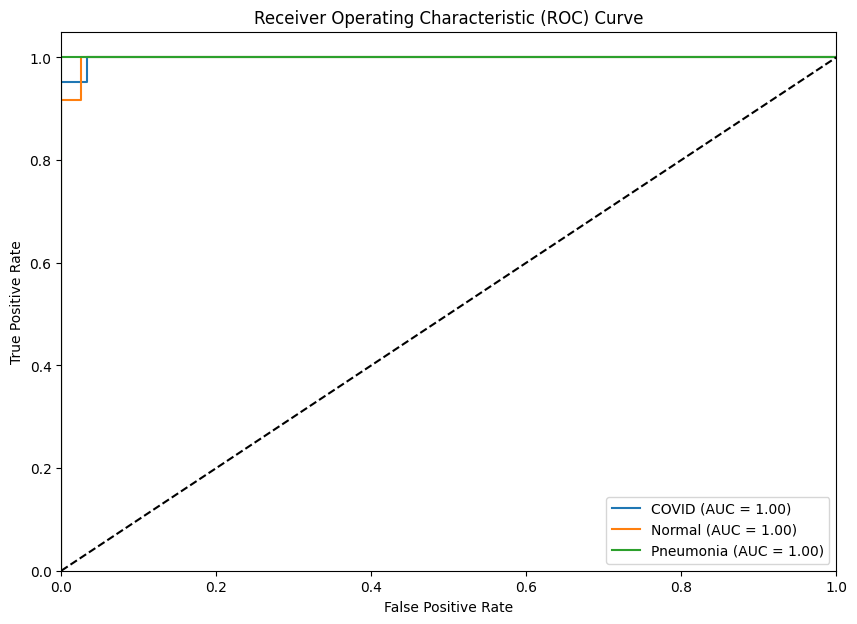

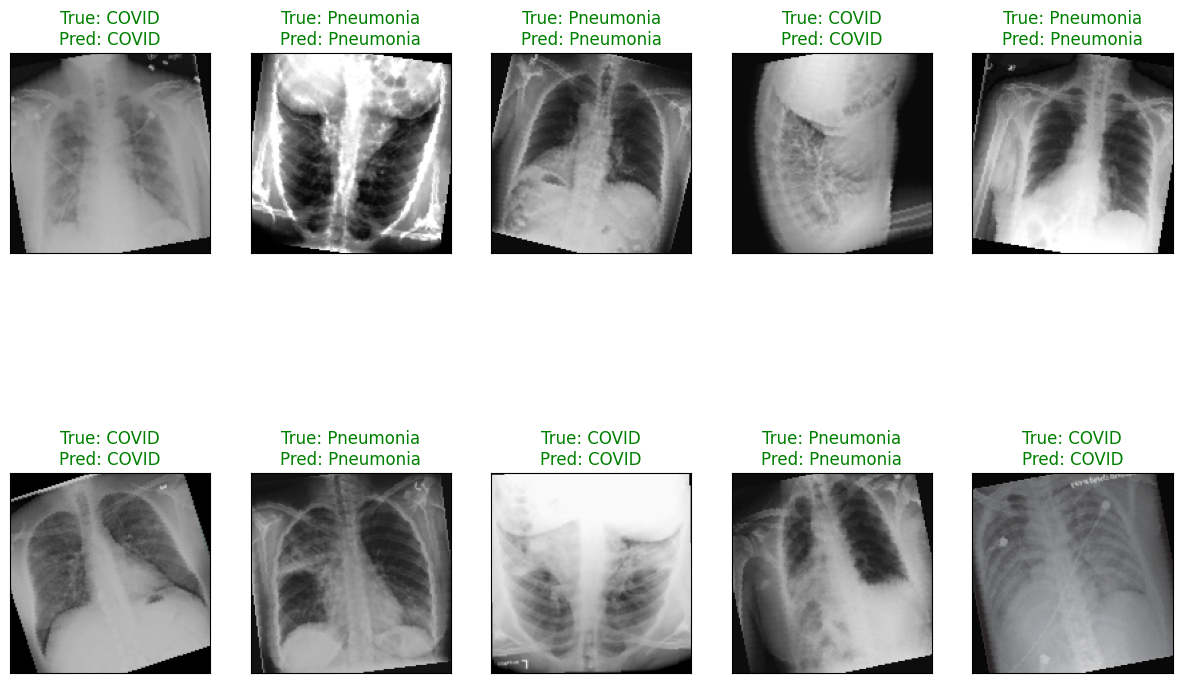

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://69935f70ca8bf5d8b5.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
from google.colab import drive
import zipfile
from PIL import Image
import matplotlib.pyplot as plt
import gradio as gr

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

path = '/content/drive/MyDrive/data/train.zip'
extract_path = '/content/drive/MyDrive/data/train'

# Ensure the zip file exists
if not os.path.exists(path):
    raise FileNotFoundError(f"Zip file '{path}' does not exist. Please check the path.")

# Extract the zip file if the directory does not exist
if not os.path.exists(extract_path):
    with zipfile.ZipFile(path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# Ensure subdirectories exist
classes = ['COVID', 'Normal', 'Pneumonia']  # Add more classes as needed
for cls in classes:
    if not os.path.exists(os.path.join(extract_path, 'train', cls)):
        raise FileNotFoundError(f"Subdirectory '{os.path.join(extract_path, 'train', cls)}' does not exist. Please check the path.")

# Custom Dataset class
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Load image paths and labels
image_paths = []
labels = []

for idx, cls in enumerate(classes):
    cls_dir = os.path.join(extract_path, 'train', cls)
    cls_paths = [os.path.join(cls_dir, img) for img in os.listdir(cls_dir) if img.endswith('.jpg')]
    image_paths.extend(cls_paths)
    labels.extend([idx] * len(cls_paths))

# Define transforms with data augmentation
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create the dataset
dataset = CustomImageDataset(image_paths, labels, transform=transform)

# Split the data into training, devset, and test sets
partitions = [0.8, 0.1, 0.1]

train_size = int(partitions[0] * len(dataset))
test_dev_size = len(dataset) - train_size
dev_size = int(partitions[1] * len(dataset))
test_size = test_dev_size - dev_size

train_data, test_dev_data = random_split(dataset, [train_size, test_dev_size])
dev_data, test_data = random_split(test_dev_data, [dev_size, test_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
dev_loader = DataLoader(dev_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Using a pre-trained ResNet50 model
class FineTunedResNet(nn.Module):
    def __init__(self):
        super(FineTunedResNet, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Sequential(
            nn.Linear(self.resnet.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, len(classes))  # Adjust for the number of classes
        )

    def forward(self, x):
        return self.resnet(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model, loss function, and optimizer with weight decay
model = FineTunedResNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)  # SGD with momentum

# Define a learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Function to train and validate the model
def train_validate(model, train_loader, dev_loader, criterion, optimizer, scheduler, num_epochs, save_path):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct / total)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in dev_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_losses.append(val_loss / len(dev_loader))
        val_accuracies.append(correct / total)

        # Save the best model based on validation accuracy
        if val_accuracies[-1] > best_val_acc:
            best_val_acc = val_accuracies[-1]
            torch.save(model.state_dict(), save_path)

        # Step the scheduler
        scheduler.step(val_loss / len(dev_loader))

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss/len(train_loader)}, Val Loss: {val_loss/len(dev_loader)}, Train Acc: {train_accuracies[-1]}, Val Acc: {val_accuracies[-1]}')

    return train_losses, val_losses, train_accuracies, val_accuracies

# Train and validate the model with the scheduler
num_epochs = 100
best_model_path = '/content/drive/MyDrive/best_fine_tuned_resnet50.pth'
train_losses, val_losses, train_accuracies, val_accuracies = train_validate(model, train_loader, dev_loader, criterion, optimizer, scheduler, num_epochs, best_model_path)

# Plotting the results
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(range(num_epochs), train_losses, label='Training Loss')
axs[0].plot(range(num_epochs), val_losses, label='Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(loc='best')
axs[0].set_title('Training and Validation Loss')

axs[1].plot(range(num_epochs), train_accuracies, label='Training Accuracy')
axs[1].plot(range(num_epochs), val_accuracies, label='Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(loc='best')
axs[1].set_title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

# Load the best model for evaluation
model.load_state_dict(torch.load(best_model_path))
model.eval()
y_pred = []
y_true = []
y_pred_prob = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.tolist())
        y_true.extend(labels.tolist())
        y_pred_prob.extend(F.softmax(outputs, dim=1).cpu().numpy())

accuracy = accuracy_score(y_true, y_pred)
print(f'Test Accuracy: {accuracy}')

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))

# Display the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Normalized confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm / cm.sum(axis=1)[:, np.newaxis], annot=True, fmt='.2%', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()

# Print classification report
print('Classification Report:')
print(classification_report(y_true, y_pred, target_names=classes))

# ROC Curve and AUC
y_true_one_hot = np.eye(len(classes))[y_true]  # One-hot encode the true labels
y_pred_prob = np.array(y_pred_prob)

fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 7))
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label=f'{classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Save the final model
torch.save(model.state_dict(), '/content/drive/MyDrive/final_fine_tuned_resnet50.pth')

# Sample Predictions Visualization
def visualize_sample_predictions(model, test_loader, classes):
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    fig = plt.figure(figsize=(15, 10))
    for idx in range(10):
        ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
        img = images[idx].cpu().numpy().transpose((1, 2, 0))
        img = (img * 0.5) + 0.5  # Unnormalize
        plt.imshow(img)
        ax.set_title(f"True: {classes[labels[idx]]}\nPred: {classes[preds[idx]]}", color=("green" if preds[idx] == labels[idx] else "red"))

    plt.show()

# Visualize sample predictions
visualize_sample_predictions(model, test_loader, classes)

# Define the Gradio interface with the updated API
def predict(image):
    image = transform(image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
        classes = ['COVID', 'Normal', 'Pneumonia']  # Adjust based on the classes in your model
        return classes[predicted.item()]

interface = gr.Interface(
    fn=predict,
    inputs=gr.components.Image(type="pil"),
    outputs=gr.components.Label()
)

# Launch the interface
interface.launch()


#Install Gradio

In [ ]:
!pip install gradio


#Deployment testing on X-vis Model

In [ ]:
import gradio as gr
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
from PIL import Image
import time

# Define the transform for the input image
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the trained ResNet50 model
class FineTunedResNet(nn.Module):
    def __init__(self):
        super(FineTunedResNet, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Sequential(
            nn.Linear(self.resnet.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 3)  # Adjust for the number of classes
        )

    def forward(self, x):
        return self.resnet(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = FineTunedResNet().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/final_fine_tuned_resnet50.pth', map_location=device))
model.eval()

# Define a function to make predictions
def predict(image):
    start_time = time.time()  # Start the timer
    image = transform(image).unsqueeze(0).to(device)  # Transform and add batch dimension

    with torch.no_grad():
        output = model(image)
        probabilities = F.softmax(output, dim=1)[0]
        top_prob, top_class = torch.topk(probabilities, 3)
        classes = ['🦠 COVID', '🫁 Normal', '🦠 Pneumonia']  # Adjust based on the classes in your model

    end_time = time.time()  # End the timer
    prediction_time = end_time - start_time  # Calculate the prediction time

    # Format the result string
    result = f"Top Predictions:\n"
    for i in range(top_prob.size(0)):
        result += f"{classes[top_class[i]]}: {top_prob[i].item() * 100:.2f}%\n"
    result += f"Prediction Time: {prediction_time:.2f} seconds"

    return result

# Example images with labels
examples = [
    ['/content/drive/MyDrive/data/train/train/Pneumonia/02009view1_frontal.jpg', '🦠 Pneumonia'],
    ['/content/drive/MyDrive/data/train/train/Pneumonia/02055view1_frontal.jpg', '🦠 Pneumonia'],
    ['/content/drive/MyDrive/data/train/train/Pneumonia/03152view1_frontal.jpg', '🦠 Pneumonia'],
    ['/content/drive/MyDrive/data/train/train/COVID/11547_2020_1200_Fig3_HTML-a.png', '🦠 COVID'],
    ['/content/drive/MyDrive/data/train/train/COVID/11547_2020_1200_Fig3_HTML-b.png', '🦠 COVID'],
    ['/content/drive/MyDrive/data/train/train/COVID/11547_2020_1203_Fig1_HTML-b.png', '🦠 COVID'],
    ['/content/drive/MyDrive/data/train/train/Normal/06bc1cfe-23a0-43a4-a01b-dfa10314bbb0.jpg', '🫁 Normal'],
    ['/content/drive/MyDrive/data/train/train/Normal/08ae6c0b-d044-4de2-a410-b3cf8dc65868.jpg', '🫁 Normal'],
    ['/content/drive/MyDrive/data/train/train/Normal/IM-0178-0001.jpeg', '🫁 Normal']
]

# Create the Gradio interface
interface = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil", label="Upload Chest X-ray Image"),
    outputs=gr.Label(label="Predicted Disease"),
    examples=examples,
    title="Lung Disease Detection XVI",
    description="Upload a chest X-ray image to detect lung diseases such as 🦠 COVID-19, 🦠 Pneumonia, or 🫁 Normal. Use the example images to see how the model works."
)

# Launch the interface
interface.launch()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://eb996783c1ad2a1a42.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


#Create the Directory Structure

In [ ]:
import os

# Create the directory structure
os.makedirs('/content/lung_disease_detection/examples/Pneumonia', exist_ok=True)
os.makedirs('/content/lung_disease_detection/examples/COVID', exist_ok=True)
os.makedirs('/content/lung_disease_detection/examples/Normal', exist_ok=True)
os.makedirs('/content/lung_disease_detection/models', exist_ok=True)


#Upload example images

In [ ]:
from google.colab import files
import os

# Function to upload images and move to the specified directory
def upload_image(category):
    try:
        print(f"Upload an example image for {category}")
        uploaded = files.upload()
        for filename in uploaded.keys():
            destination = f'/content/lung_disease_detection/examples/{category}/{filename}'
            print(f"Moving {filename} to {destination}")
            os.rename(filename, destination)
            print(f"{filename} moved to {destination}")
    except Exception as e:
        print(f"Error uploading file for {category}: {e}")

# Upload example images one at a time

# Run this cell to upload an image for Pneumonia
upload_image('Pneumonia')

# Run this cell to upload an image for COVID
upload_image('COVID')

# Run this cell to upload an image for Normal
upload_image('Normal')


Upload an example image for Pneumonia


Error uploading file for Pneumonia: RangeError: Maximum call stack size exceeded.
Upload an example image for COVID


Saving COVID-3553.png to COVID-3553.png
Moving COVID-3553.png to /content/lung_disease_detection/examples/COVID/COVID-3553.png
COVID-3553.png moved to /content/lung_disease_detection/examples/COVID/COVID-3553.png
Upload an example image for Normal


Error uploading file for Normal: RangeError: Maximum call stack size exceeded.


#Mount google drive

In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Create directory for lung disease detection if it doesn't exist
os.makedirs('/content/drive/MyDrive/lung_disease_detection/models', exist_ok=True)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Access and Move model file

In [ ]:
import shutil

# Source path for the model file in Google Drive
model_source_path = '/content/drive/MyDrive/lung_disease_detection/models/final_fine_tuned_resnet50.pth'

# Destination path for the model file in Colab
model_destination_path = '/content/lung_disease_detection/models/final_fine_tuned_resnet50.pth'

# Try to move the file
try:
    print(f"[INFO] Attempting to move {model_source_path} to {model_destination_path}")

    # Move the model
    shutil.move(src=model_source_path, dst=model_destination_path)

    print(f"[INFO] Model move complete.")
except Exception as e:
    print(f"[INFO] No model found at {model_source_path}, perhaps it's already been moved?")
    print(f"[INFO] Model exists at {model_destination_path}: {os.path.exists(model_destination_path)}")
    print(f"Error: {e}")


[INFO] Attempting to move /content/drive/MyDrive/lung_disease_detection/models/final_fine_tuned_resnet50.pth to /content/lung_disease_detection/models/final_fine_tuned_resnet50.pth
[INFO] Model move complete.


#Requirements

In [ ]:
with open('/content/lung_disease_detection/requirements.txt', 'w') as f:
    f.write('gradio\n')
    f.write('torch\n')
    f.write('torchvision\n')
    f.write('Pillow\n')


#model.py

In [ ]:
%%writefile /content/lung_disease_detection/model.py
import torch
import torchvision
from torch import nn

class FineTunedResNet(nn.Module):
    def __init__(self, num_classes=3):
        super(FineTunedResNet, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Sequential(
            nn.Linear(self.resnet.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)


Overwriting /content/lung_disease_detection/model.py


#app.py

In [ ]:
%%writefile /content/lung_disease_detection/app.py
import gradio as gr
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
from model import FineTunedResNet
import time

# Define the transform for the input image
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the trained ResNet50 model
model = FineTunedResNet(num_classes=3)
model.load_state_dict(torch.load('/content/lung_disease_detection/models/final_fine_tuned_resnet50.pth', map_location=torch.device('cpu')))
model.eval()

# Define a function to make predictions
def predict(image):
    start_time = time.time()  # Start the timer
    image = transform(image).unsqueeze(0)  # Transform and add batch dimension

    with torch.no_grad():
        output = model(image)
        probabilities = F.softmax(output, dim=1)[0]
        top_prob, top_class = torch.topk(probabilities, 3)
        classes = ['🦠 COVID', '🫁 Normal', '🦠 Pneumonia']  # Adjust based on the classes in your model

    end_time = time.time()  # End the timer
    prediction_time = end_time - start_time  # Calculate the prediction time

    # Format the result string
    result = f"Top Predictions:\\n"
    for i in range(top_prob.size(0)):
        result += f"{classes[top_class[i]]}: {top_prob[i].item() * 100:.2f}%\\n"
    result += f"Prediction Time: {prediction_time:.2f} seconds"

    return result

# Example images with labels
examples = [
    ['examples/Pneumonia/02009view1_frontal.jpg', '🦠 Pneumonia'],
    ['examples/Pneumonia/02055view1_frontal.jpg', '🦠 Pneumonia'],
    ['examples/Pneumonia/03152view1_frontal.jpg', '🦠 Pneumonia'],
    ['examples/COVID/11547_2020_1200_Fig3_HTML-a.png', '🦠 COVID'],
    ['examples/COVID/11547_2020_1200_Fig3_HTML-b.png', '🦠 COVID'],
    ['examples/COVID/11547_2020_1203_Fig1_HTML-b.png', '🦠 COVID'],
    ['examples/Normal/06bc1cfe-23a0-43a4-a01b-dfa10314bbb0.jpg', '🫁 Normal'],
    ['examples/Normal/08ae6c0b-d044-4de2-a410-b3cf8dc65868.jpg', '🫁 Normal'],
    ['examples/Normal/IM-0178-0001.jpeg', '🫁 Normal']
]

# Create the Gradio interface
interface = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil", label="Upload Chest X-ray Image"),
    outputs=gr.Label(label="Predicted Disease"),
    examples=examples,
    title="Lung Disease Detection XVI",
    description="Upload a chest X-ray image to detect lung diseases such as 🦠 COVID-19, 🦠 Pneumonia, or 🫁 Normal. Use the example images to see how the model works."
)

# Launch the interface
interface.launch()


Overwriting /content/lung_disease_detection/app.py


#Push to Hugging Face Spaces

In [ ]:
!apt-get install git-lfs


In [ ]:
import os

# Configure git with your username and token
os.system('git config --global user.email "resberrypi@gmail.com"')
os.system('git config --global user.name "resberry"')

# Clone the Hugging Face Space repository
os.system('git clone https://huggingface.co/spaces/resberry/X-vis')
os.chdir('X-vis')

# Copy files from Colab to the cloned repository
os.system('cp -r /content/lung_disease_detection/* .')

# Add, commit, and push the files
os.system('git add .')
os.system('git commit -m "Initial commit"')
os.system('git push')


32768